# MVA Reinforcement Learning 2017 - Homework 1
## WANG Yifan

In [58]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from gridworld import GridWorld1
import gridrender as gui
env = GridWorld1

## Q1: Implement the discrete MDP model.

In [2]:
class MDP(object):
    def __init__(self, proba, reward, gamma):
        self.proba = proba
        self.reward = reward
        self.gamma = gamma

        self.ns = self.proba.shape[0]
        self.na = self.proba.shape[1]
        self.states = range(self.ns)
        self.actions = range(self.na)
        self.V = np.zeros(self.ns)
        self.Q = np.zeros((self.ns, self.na))
        
        self.value_history = None
    
    def _reset(self):
        self.ns = self.proba.shape[0]
        self.na = self.proba.shape[1]
        self.states = range(self.ns)
        self.actions = range(self.na)
        self.V = np.zeros(self.ns)
        self.Q = np.zeros((self.ns, self.na))
        self.value_history = None        

    def proba(self, s0,  a,  s1):
        return self.proba[s0, a, s1]

    def proba(self, s0, a):
        return self.proba[s0, a, :]

    def reward(self, s0, a):
        return self.reward[s0, a]

    def value_iteration(self, get_values=False, verbal=False):
        if get_values:
            self._reset()
            self.value_history = [self.V.copy()]
        V = self.V.copy()
        turn = 0
        
        if verbal:
            start = time.time()
        while np.abs(V - self.V).max() > 0.01 or turn == 0:
            V = self.V.copy()
            turn += 1
            for s in self.states:
                for a in self.actions:
                    self.Q[s, a] = self.reward[s, a] + self.gamma * self.proba[s, a, :].dot(V)
                self.V[s] = np.max(self.Q[s, :])

            if get_values:
                # append the copy or the rows will be the same
                self.value_history.append(self.V.copy())
        if verbal:
            print("{0} turns, takes {1:.5f} seconds".format(turn, time.time() - start))
        if get_values:
            self.value_history = np.array(self.value_history)
        return self.V
        

    def policy_evaluation(self, policy):
        P_pi = np.zeros((self.ns, self.ns))
        r_pi = np.zeros((self.ns))
        for i in self.states:
            r_pi[i] = self.reward[i, policy[i]]
            for j in self.states:
                P_pi[i,j] = self.proba[i, policy[i], j]
        # Direct computation of value function given policy
        V_pi = np.linalg.inv(np.eye((self.ns)) - self.gamma*P_pi).dot(r_pi)
        return V_pi
    
    def policy_iteration(self, init_policy=None, verbal=False):
        if init_policy is None:
            # arbitary initial policy
            new_pi = np.random.randint(self.na, size=self.ns)
        V_pi = self.policy_evaluation(new_pi)
        # policy improvement
        pi = new_pi.copy()
        turn = 0
        if verbal:
            start = time.time()
        while np.abs(pi - new_pi).max() > 0 or turn == 0:
            pi = new_pi.copy()
            turn += 1
            for s in self.states:
                new_pi[s] = np.argmax(self.reward[s] + self.gamma * self.proba[s].dot(V_pi))
            V_pi = self.policy_evaluation(new_pi)
        if verbal:
            print("{0} turns, takes {1:.5f} seconds".format(turn, time.time() - start))
        return new_pi

## Q2: Implement and run value iteration (VI) in order to identify a 0.01–optimal policy

Implementation is in the MDP class

In [527]:
reward = np.zeros((3, 2))
reward[0,0] = -0.4
reward[0,1] = 0
reward[1, 0] = 2
reward[1, 1] = 0
reward[2, 0] = -1
reward[2, 1] = -0.5

proba = np.zeros((3,2,3))
proba[0,0,0] = 0.45
proba[0,0,2] = 0.55
proba[0,1,2] = 1
proba[1,0,2] = 1
proba[1,1,0] = 0.5
proba[1,1,1] = 0.4
proba[1,1,2] = 0.1
proba[2,0,0] = 0.6
proba[2,0,1] = 0.4
proba[2,1,1] = 0.9
proba[2,1,2] = 0.1

mdp = MDP(proba, reward, gamma=0.95)
mdp.value_iteration()
print("value function of a 0.01–optimal policy: \n", mdp.V)

value function of a 0.01–optimal policy: 
 [ 12.20945133  14.20945133  12.86174503]


In [528]:
policy_best = [1, 0, 1]
value_best = mdp.policy_evaluation(policy_best)
print("Optimal value function by evaluating the optimal policy:\n", value_best)

Optimal value function by evaluating the optimal policy:
 [ 12.393531   14.393531   13.0458221]


84 turns, takes 0.00302 seconds


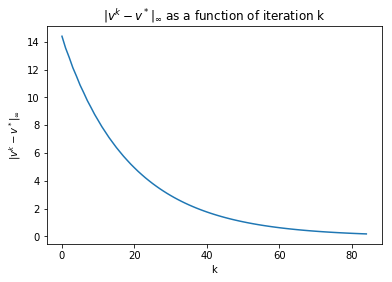

In [9]:
mdp.value_iteration(get_values=True, verbal=True)
values = mdp.value_history
k = values.shape[0]
plt.plot(range(k), [np.abs(v - value_best).max() for v in values])
plt.title("$|v^k-v^*|_{\infty}$ as a function of iteration k")
plt.xlabel('k')
plt.ylabel("$|v^k-v^*|_{\infty}$")
plt.show()

## Q3: implement policy iteration (PI) with arbitrary initial policy. Compare the speed of convergence w.r.t. VI and discuss the relative merits of the two approaches.

Implementation is in the MDP class

In [10]:
pi = mdp.policy_iteration(verbal=True)
print("Result of policy iteration:", pi)

2 turns, takes 0.00052 seconds
Result of policy iteration: [1 0 1]


We can see that value iteration takes 84 turns and 0.00302 seconds to converge, while policy iteration only takes 2 turns and 0.00052 seconds. The policy iteration, in our case, converges around 6 times faster than value iteration.

However, policy iteration needs to perform a policy evaluation each turn which could be expensive, while each value iteration is efficient. Policy iteration can converge in a finite number of iterations, while value iteration converges only asymptotically. Once we need an very precise approximation, the value iteration could take a very long time to converge.

# 2 Reinforcement Learning
## Q4: Monte-Carlo estimation

In [62]:
# The grid world
# X0 X1 X2 X3
# X4 ## X5 X6
# X7 X8 X9 X10
# policy: right if possible -> up
# actions:
# 0: right
# 1: down
# 2: left
# 3: up
# state[3] and state[6] are absorbing

def simulate(policy, n, Tmax):
    states = []
    actions = []
    rewards = []
    for e in range(n):
        x = []
        a = []
        r = []
        x.append(env.reset())
        t = 0
        term = False
        while (t < Tmax and not term):
            a.append(pi[x[t]])
            x_new, r_new, term = env.step(x[t], a[t])
            x.append(x_new)
            r.append(r_new)
            t += 1
        states.append(x)
        actions.append(a)
        rewards.append(r)
    return states, actions, rewards

def discounted_reward(r, gamma):
    re = r[-1]
    for i in range(len(r)-1):
        re = re * gamma + r[-i-2]
    return re

In [530]:
# MC estimator of Q and V
def MC(states, actions, rewards, gamma, ns, na, policy):
    Q_sum = np.zeros((ns, na))
    N = np.zeros((ns, na)) + 1e-8
    V = np.zeros(ns)
    Js = []
    for s, a, r in zip(states[:-1], actions, rewards):
        Q_sum[s[0], a[0]] += discounted_reward(r, gamma)
        N[s[0], a[0]] += 1
        Q = Q_sum / N
        for i in range(ns):
            V[i] = Q[i, policy[i]]
        Js.append(np.mean(V))
    return np.array(Q), np.array(V), np.array(Js)

In [531]:
pi = np.array([0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3 ])
ns = 11
na = 4
states = range(ns)
actions = range(na)
gamma = 0.95
states, actions, rewards = simulate(pi, n=4000, Tmax=30)
Q, V, Js = MC(states, actions, rewards, gamma, ns, na, pi)
print('Q-value function\n', Q)
print('Value function\n', V)

Q-value function
 [[ 0.87610291  0.          0.          0.        ]
 [ 0.9212408   0.          0.          0.        ]
 [ 0.99073603  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.69671076]
 [-0.99534938  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.82773692  0.          0.          0.        ]
 [-0.87667148  0.          0.          0.        ]
 [-0.9368062   0.          0.          0.        ]
 [ 0.          0.          0.         -0.99504261]]
Value function
 [ 0.87610291  0.9212408   0.99073603  0.          0.69671076 -0.99534938
  0.         -0.82773692 -0.87667148 -0.9368062  -0.99504261]


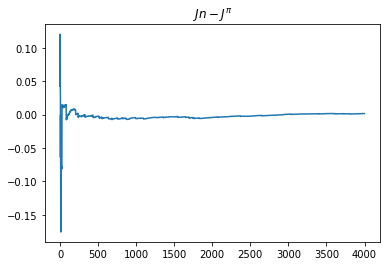

In [535]:
V_pi = np.array([0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.67106071, -0.99447514, 0.00000000, -0.82847001, -0.87691855,
        -0.93358351, -0.99447514])
q_q4 = np.array([[0.87691855, 0.65706417, 0, 0],
        [0.92820033,0, 0.84364237, 0],
        [0.98817903, -0.75639924, 0.89361129, 0],
        [0.00000000, 0, 0, 0],
        [0, -0.62503460, 0, 0.67106071],
        [-0.99447514, -0.70433689, 0, 0.75620264],
        [0.00000000, 0, 0,0],
        [-0.82847001,0, 0 ,0.49505225],
        [-0.87691855,0, -0.79703229,0],
        [-0.93358351,0, -0.84424050, -0.93896668],
        [0,0,-0.89268904, -0.99447514]
        ])

J_pi = np.mean(V_pi)
plt.plot(range(Js.shape[0]), Js - J_pi)
plt.title('$Jn - J^{\pi}$')
plt.show()

The differences of $J_n - J^{\pi}$ are shown above.

## Q5. Q-Learning

In [503]:
v_opt = np.array([0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.82369294, 0.92820033, 0.00000000, 0.77818504, 0.82369294,
         0.87691855, 0.82847001])
ns = 11
na = 4
gamma = 0.95

def Qlearning(n, Tmax, eps, lr, gamma, ns, na):
    """
    lr: a function lr(t, x, a)
    """
    Q = np.zeros((ns, na))
    N = np.zeros((ns, na))
    V = np.zeros(ns)
    Vs = []
    # simulate
    for e in range(n):
        x = env.reset()
        t = 0
        term = False
        while (t < Tmax and not term):
            if np.random.rand(1) > eps and np.argmax(Q[x]) in env.state_actions[x]:
                # greedy action
                a = np.argmax(Q[x])
            else:
                # random action
                a = np.random.choice(env.state_actions[x])
            N[x, a] += 1
            x_new, r, term = env.step(x, a)
            t += 1
            alpha = lr(N[x,a],x,a)
            Q[x, a] = (1-alpha)*Q[x,a] + alpha*(r + gamma*np.max(Q[x_new]))
            x = x_new
        V = np.zeros(ns)
        for x in range(ns):
            V[x] = np.max(Q[x])
        Vs.append(V)
            
    return Q, V, N, Vs

def plot(Vs):
    plt.plot(range(len(Vs)), [np.abs(v - v_opt).max() for v in Vs]) 


In [536]:
n = 4000
Q1, V1, N1, Vs1 = Qlearning(n, 30, 0.01, lambda n,x,a:0.1, gamma, ns, na)
Q2, V2, N2, Vs2 = Qlearning(n, 30, 0.1, lambda n,x,a:0.1, gamma, ns, na)
Q3, V3, N3, Vs3 = Qlearning(n, 30, 0.5, lambda n,x,a:0.1, gamma, ns, na)
Q4, V4, N4, Vs4 = Qlearning(n, 30, 0.9, lambda n,x,a:0.1, gamma, ns, na)

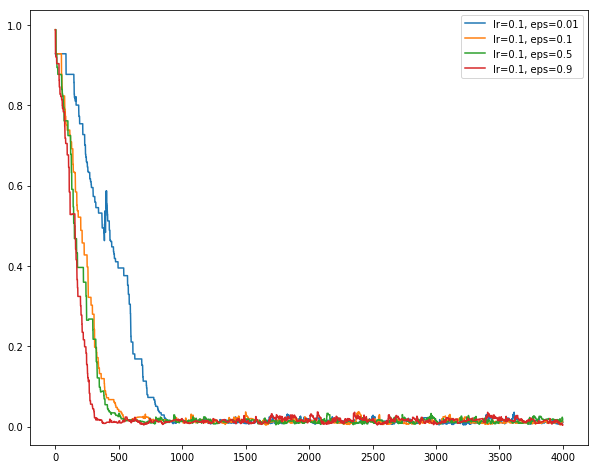

In [537]:
plt.figure(figsize=(10,8))
plot(Vs1)
plot(Vs2)
plot(Vs3)
plot(Vs4)
plt.legend(("lr=0.1, eps=0.01", 'lr=0.1, eps=0.1', "lr=0.1, eps=0.5", "lr=0.1, eps=0.9"))
plt.show()

### Influence of $\epsilon$

We can see that when $\epsilon$ increases, the algorithm converges faster, but this influence is not very important. Besides, a small exploration rate can reduce the vibration of the curve. This is because the algorithm needs to gather enough information to converge, and with a large $\epsilon$, it can gather information faster. However, a large  $\epsilon$ also means not following the current optimal policy, which leads to the vibration when we already gather much information.

In [548]:
Q5, V5, N5, Vs5 = Qlearning(n, 30, 0.1, lambda n,x,a:1./(n+1), gamma, ns, na)
Q6, V6, N6, Vs6 = Qlearning(n, 30, 0.1, lambda n,x,a:1./np.sqrt(n+1), gamma, ns, na)
Q7, V7, N7, Vs7 = Qlearning(n, 30, 0.1, lambda n,x,a:1./np.log(n+2), gamma, ns, na)
Q0, V0, N0, Vs0 = Qlearning(n, 30, 0.9, lambda n,x,a:0.01, gamma, ns, na)

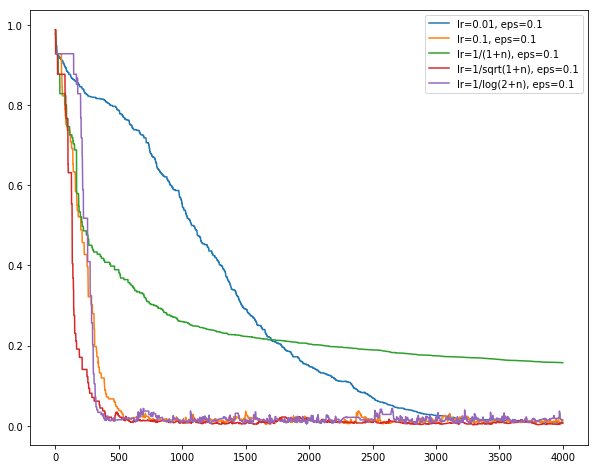

In [549]:
plt.figure(figsize=(10,8))
plot(Vs0)
plot(Vs2)
plot(Vs5)
plot(Vs6)
plot(Vs7)
plt.legend(("lr=0.01, eps=0.1", "lr=0.1, eps=0.1", 'lr=1/(1+n), eps=0.1', "lr=1/sqrt(1+n), eps=0.1", "lr=1/log(2+n), eps=0.1"))
plt.show()

### Influence of learning rate $\alpha$

If $\alpha=\frac{1}{n+1}$, we can demonstrate that the algorithm will converge, but it turns out that it will take a very long time. In practice, a small constant learning rate works well. Our experiments show that $\alpha=\frac{1}{\sqrt{n+1}}$ is also a good idea, which makes the loss ($|v^*-v^{\pi_n}|_\infty$) decrease faster and more smoothly.

We can also see that a larger constant learning rate makes the loss decrease faster, but less smoothly. This is because after a great number of iteration, the estimation should be quite close to the optimal value, a large learning rate can however change the estimated values a lot. So a good iead is to decrease the learning rate.

In [550]:
Q8, V8, N8, Vs8 = Qlearning(200000, 30, 0.1, lambda n,x,a:1./(n+1), gamma, ns, na)

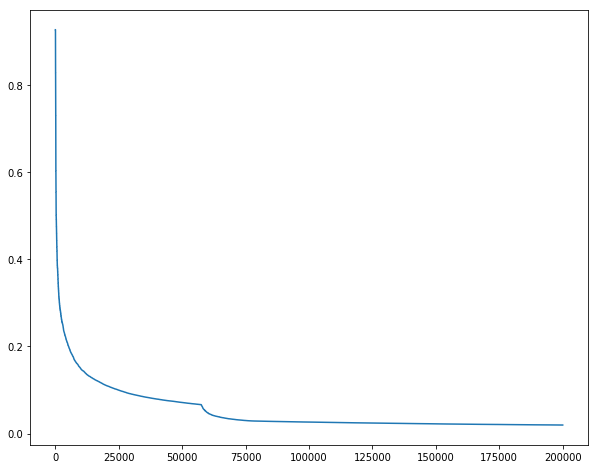

In [551]:
plt.figure(figsize=(10,8))
plot(Vs8)
plt.show()

## Q6. Is the optimal policy of an MDP aﬀected by the change of the initial distribution $µ_0$ ?

No, the initial distribution of an MDP won't change the optimal policy. MDP has Markov propterty, which means the future state is independent from the past given the current state, we know that $V^*$ is the unique fixed point of optimal Bellman operation, which leads to a unique optimal policy.